In [1]:
import sys
if "../" not in sys.path: sys.path.append("../")
import pickle
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm

# import seaborn as sns
# sns.set(rc={'figure.facecolor':'white'})
# plt.rcParams["figure.facecolor"] = "white"

%matplotlib inline
%load_ext autoreload
%autoreload 2

from analysis_helpers import *

from eye_tracking.eye_tracking import get_stim_at_frame, get_saccade_magnitude_direction
from experiment.cre_line import match_cre_line
from eye_plotting import STIM_ABBREV, STIM_COLORS
from saccade_config import *

# Manually test inclusion

In [2]:
files_to_process = glob.glob(path.join(LOADED_CELL_DATA_DIR, f"*.pickle"))
corrected_p_thresh = 5e-4
n_boot = int(20 * (1/corrected_p_thresh))
print(f"Using {n_boot:,} bootstraps; corrected p-value threshold: {corrected_p_thresh:.2e}")
slice_after = slice(0, 10)
slice_before = slice(-45, -15)

# Load a list of sessions for every cell
cell_to_sessions = {}

for filename in tqdm(files_to_process):
    with open(filename, "rb") as file:
        data = pickle.load(file)
    
    session_id = data["session_data"]["session_id"]

    for cell in data["cell_specimen_ids"]:
        if cell in cell_to_sessions:
            sessions = cell_to_sessions[cell]
            if session_id not in sessions:
                sessions.append(session_id)
        else:
            cell_to_sessions[cell] = [session_id]

print(f"There are {len(cell_to_sessions):,} cells across {len(files_to_process)} sessions.")

# Determine a list of cells for every combination of sessions
sessions_to_cells = {}

for cell, sessions in cell_to_sessions.items():
    key = tuple(sorted(sessions))
    if key in sessions_to_cells:
        sessions_to_cells[key].append(cell)
    else:
        sessions_to_cells[key] = [cell]

print(f"There are {len(sessions_to_cells):,} different combinations of sessions that load all cells.")

args = []

for sessions, cell_specimen_ids in sessions_to_cells.items():
    session_filenames = [ path.join(LOADED_CELL_DATA_DIR, f"{session_id}.pickle") for session_id in sessions]
    args.append((session_filenames, cell_specimen_ids, slice_after, slice_before, corrected_p_thresh, n_boot))

Using 40,000 bootstraps; corrected p-value threshold: 5.00e-04


100%|██████████| 818/818 [00:19<00:00, 42.38it/s]

There are 43,316 cells across 818 sessions.
There are 1,594 different combinations of sessions that load all cells.


In [17]:
n_cells_n_saccades = [] # (n_cells, n_total, n_left, n_right)

for j in tqdm(range(len(args))):
    session_filenames, cell_specimen_ids = args[j][:2]
    datas = []

    for filename in session_filenames:
        with open(filename, "rb") as file:
            data = pickle.load(file)
            datas.append(data)
    
    n_left, n_right = 0, 0
    saccade_padding = 2*30
    saccades = []
    sacc_dirs = []
    allowed_stimuli = ["spontaneous"] # None for all stimuli

    for data_i, data in enumerate(datas):
        start, end = data["start_end"]

        for ss, se in data["saccades"]:
            if ss-start < saccade_padding or end-se < saccade_padding:
                # Ignore saccades that happen too close to the end
                continue
            elif len(saccades) > 0 and saccades[-1][0] == data_i and ss - saccades[-1][2] <= saccade_padding:
                # Ignore saccades that happen too close to each other
                continue

            if allowed_stimuli is not None:
                if get_stim_at_frame(data["stim_epoch"], frame=ss) not in allowed_stimuli:
                    continue

            saccades.append((data_i, ss, se))
            mag, dir = get_saccade_magnitude_direction(data["eye_tracking"], ss, se)
            sacc_dirs.append(dir)
            if dir == "L": n_left += 1
            elif dir == "R": n_right += 1

    # print(f"n_left={n_left}, n_right={n_right}")
    n_cells_n_saccades.append((len(cell_specimen_ids), len(saccades), n_left, n_right))

100%|██████████| 1594/1594 [07:39<00:00,  3.47it/s]


In [21]:
X = np.array(n_cells_n_saccades)
total_n_cells = X[:, 0].sum()

print("Number of cells with ≥k N/T saccades:")
for k in range(3, 16):
    n = X[(X[:, 2] >= k) & (X[:, 2] >= k)][:, 0].sum()
    print(f"k = {k}: {n}/{total_n_cells} ({n/total_n_cells*100:.2f}%)")

Number of cells with ≥k N/T saccades:
k = 3: 30764/43316 (71.02%)
k = 4: 28066/43316 (64.79%)
k = 5: 25311/43316 (58.43%)
k = 6: 23778/43316 (54.89%)
k = 7: 22105/43316 (51.03%)
k = 8: 20837/43316 (48.10%)
k = 9: 19970/43316 (46.10%)
k = 10: 19197/43316 (44.32%)
k = 11: 18113/43316 (41.82%)
k = 12: 17336/43316 (40.02%)
k = 13: 16558/43316 (38.23%)
k = 14: 16207/43316 (37.42%)
k = 15: 15525/43316 (35.84%)


# Analyze results of using only spontaneous saccades

In [2]:
df_spont = pd.read_csv(LOADED_CLASSIFIED_CELLS_SPONTANEOUS_CSV, index_col=0)
df_all = pd.read_csv(LOADED_CLASSIFIED_CELLS_CSV, index_col=0)
add_cell_df_columns(df_spont)
add_cell_df_columns(df_all)
len(df_all), len(df_spont)

(32442, 27912)

In [25]:
ood = "Not in Data"
cls_types = [x[0] for x in SR_LABELS] + [ood]
df_change = pd.DataFrame(index=[f"{x}" for x in cls_types], columns=cls_types, dtype=int, data=0)
df_change.index.rename("All Stimuli:", inplace=True)
df_change.columns.rename("Spontaneous:", inplace=True)
df_change

for cell_id in tqdm(np.union1d(df_all.index, df_spont.index)):
    all_type = df_all.loc[cell_id, "sr_label"] if cell_id in df_all.index else ood
    spont_type = df_spont.loc[cell_id, "sr_label"] if cell_id in df_spont.index else ood
    df_change.loc[all_type, spont_type] += 1

df_change

  0%|          | 0/33063 [00:00<?, ?it/s]

Spontaneous:,No response,Suppressed,Enhanced: No DS,Enhanced: Nasal,Enhanced: Temporal,Not in Data
All Stimuli:,,,,,,
No response,23872,187,335,29,136,4812
Suppressed,285,67,0,0,0,23
Enhanced: No DS,669,0,106,7,8,121
Enhanced: Nasal,223,0,39,41,2,13
Enhanced: Temporal,968,0,117,4,196,182
Not in Data,612,3,6,0,0,0


In [26]:
df_change.div(df_change.sum(axis=1), axis=0).applymap(lambda x: f"{x*100:.0f}%" if np.isfinite(x) else "-")

Spontaneous:,No response,Suppressed,Enhanced: No DS,Enhanced: Nasal,Enhanced: Temporal,Not in Data
All Stimuli:,,,,,,
No response,81%,1%,1%,0%,0%,16%
Suppressed,76%,18%,0%,0%,0%,6%
Enhanced: No DS,73%,0%,12%,1%,1%,13%
Enhanced: Nasal,70%,0%,12%,13%,1%,4%
Enhanced: Temporal,66%,0%,8%,0%,13%,12%
Not in Data,99%,0%,1%,0%,0%,0%


# Examine distributions

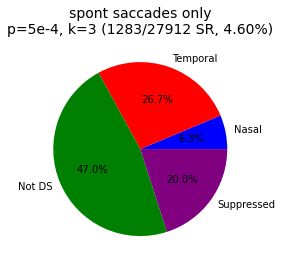

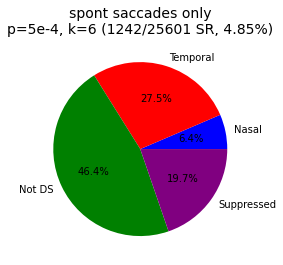

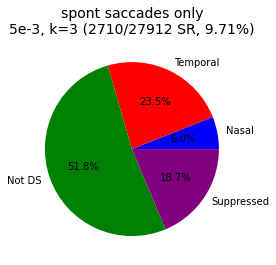

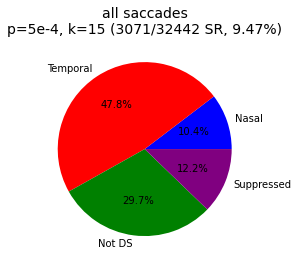

In [5]:
# We still see a huge temporal bias
DF_CONFIGS = ((df_spont, "spont saccades only\np=5e-4, k=3", 5e-4, 3), (df_spont, "spont saccades only\np=5e-4, k=6", 5e-4, 6), (df_spont, "spont saccades only\n5e-3, k=3", 5e-3, 3), (df_all, "all saccades\np=5e-4, k=15", 5e-4, 15))
for df, name, p_thresh, k in DF_CONFIGS:
    response_classification = df.p_value.apply(lambda p: 1 if p < p_thresh else -1 if p > 1-p_thresh else 0)
    response_classification = response_classification[(df.n_left >= k) | (df.n_right >= k)]
    n_sr = (response_classification != 0).sum()
    n_not_sr = (response_classification == 0).sum()
    n_nasal = ((response_classification == 1) & (df.ranksum_p_by_direction < 0.05) & (df.mean_left_response > df.mean_right_response)).sum()
    n_temporal = ((response_classification == 1) & (df.ranksum_p_by_direction < 0.05) & (df.mean_left_response < df.mean_right_response)).sum()
    n_not_ds = ((response_classification == 1) & (df.ranksum_p_by_direction > 0.05)).sum()
    n_suppressed = (response_classification == -1).sum()
    # print(n_spont_not_ds, n_spont_nasal, n_spont_temporal, n_spont_suppressed)

    plt.figure()
    # plt.pie(x=[n_not_sr, n_nasal, n_temporal, n_not_ds, n_suppressed], labels=["Not SR", "Nasal", "Temporal", "Not DS", "Suppressed"], colors=["gray", "b", "r", "green", "purple"], autopct="%1.1f%%")
    plt.pie(x=[n_nasal, n_temporal, n_not_ds, n_suppressed], labels=["Nasal", "Temporal", "Not DS", "Suppressed"], colors=["b", "r", "green", "purple"], autopct="%1.1f%%")
    plt.title(f"{name} ({n_sr}/{len(response_classification)} SR, {(response_classification != 0).mean()*100:.2f}%)", fontsize=14)

In [29]:
for df in (df_spont, df_all):
    df["depth_trunc"] = 100 * (df["depth"]/100).astype(int)
    df.at[df["cre_line"] == "Scnn1a-Tg3-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f)", "depth_trunc"] = 200
    df.at[df["cre_line"] == "Nr5a1-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f)", "depth_trunc"] = 200
    df.at[df["cre_line"] == "Fezf2-CreER; Ai148(TIT2L-GC6f-ICL-tTA2)", "depth_trunc"] = 300
    df.at[df["depth_trunc"] == 400, "depth_trunc"] = 300

    depth_to_layer = {
        100: "2/3",
        200: "4",
        300: "5",
        500: "6",
    }

    df["cortical_layer"] = df["depth_trunc"].apply(depth_to_layer.get)

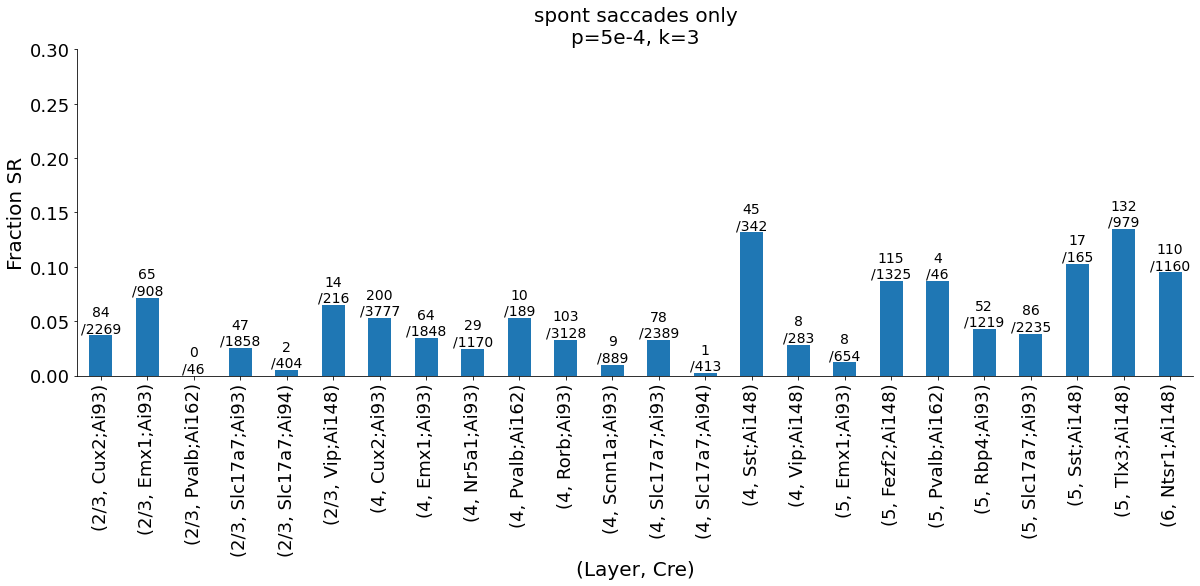

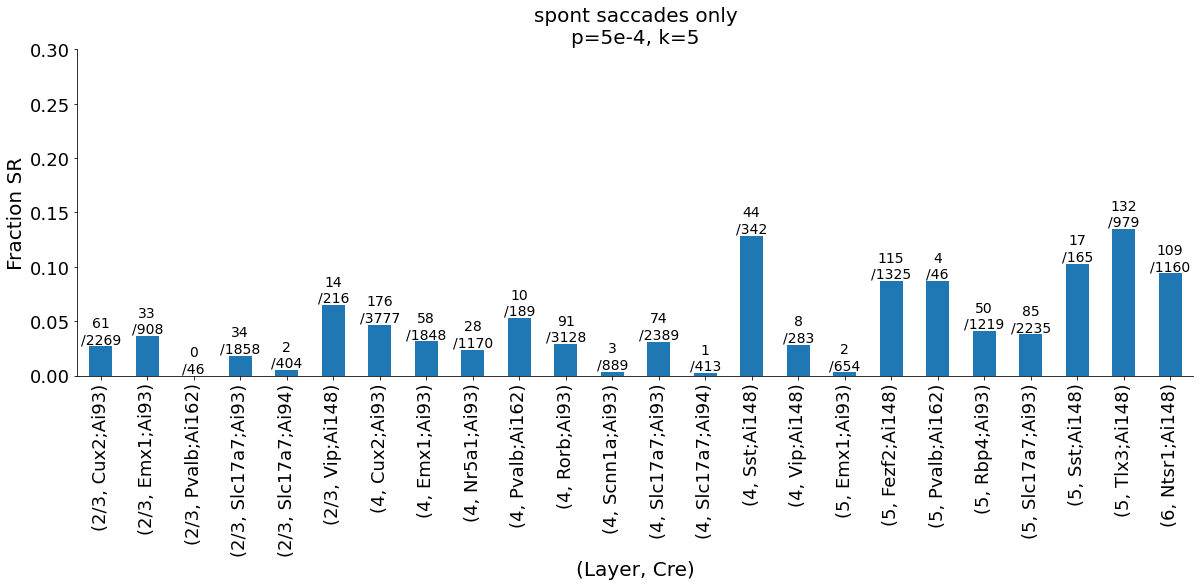

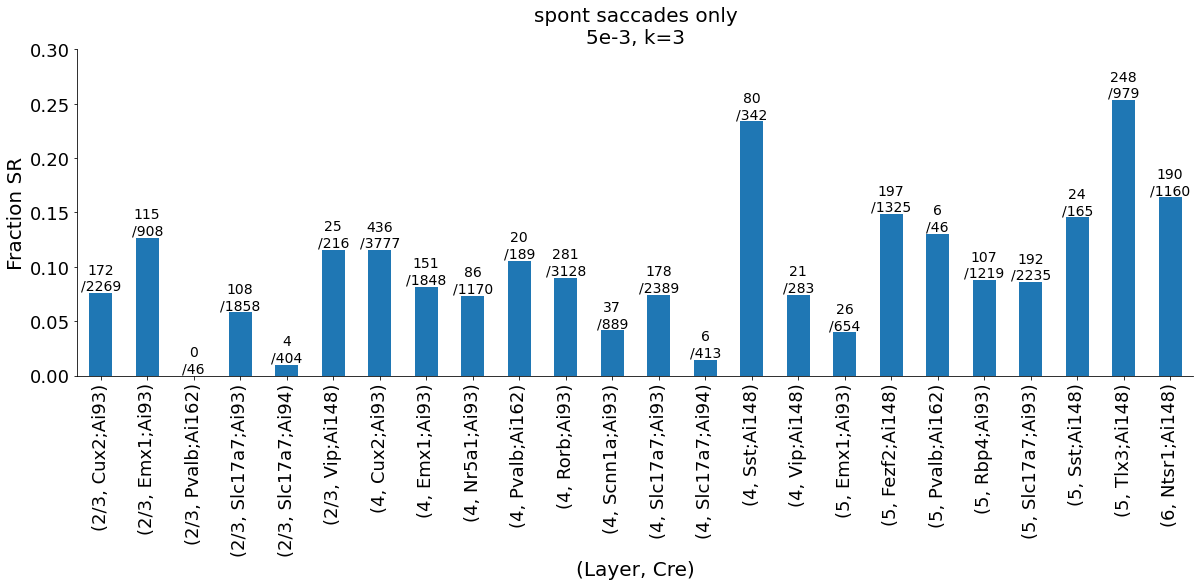

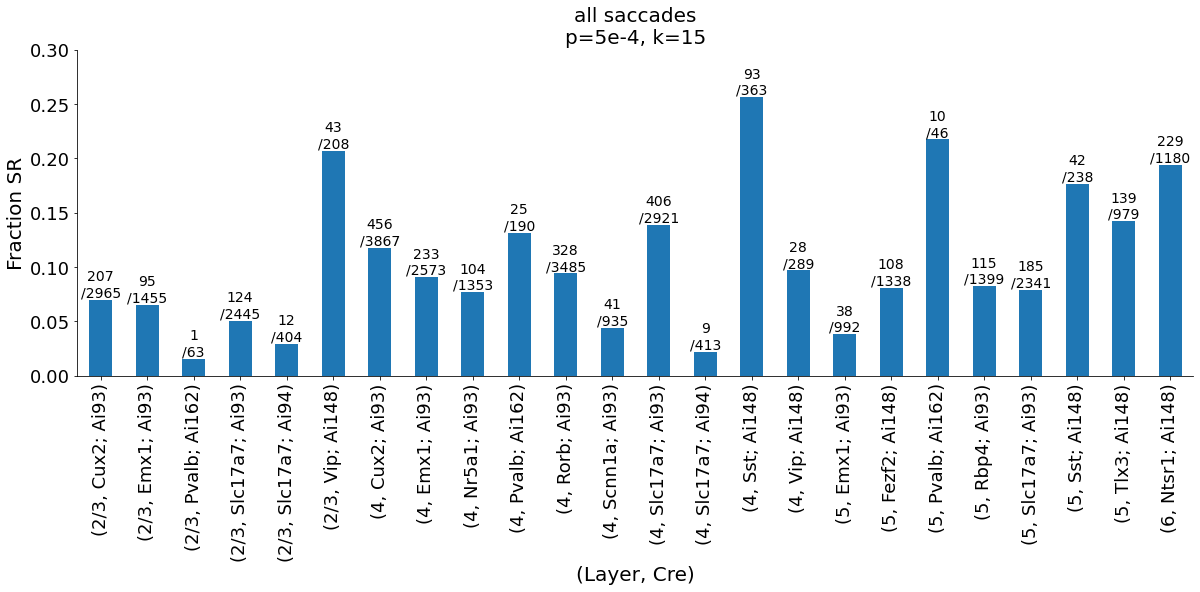

In [30]:
# Plot saccade responsiveness by cre
for df, name, p_thresh, k in DF_CONFIGS:
    response_classification = df.p_value.apply(lambda p: 1 if p < p_thresh else -1 if p > 1-p_thresh else 0)
    response_classification[(df.n_left < k) | (df.n_right < k)] = 0
    df["is_sr"] = response_classification != 0

    # df_spont.groupby(["depth", "cre_abbrev"])["is_sr"].mean().plot(kind="bar", figsize=(20, 6), fontsize=18)
    # plt.xlabel("(Depth, Cre)", fontsize=20)
    fig, ax = plt.subplots(figsize=(20, 6))
    to_plot = df.groupby(["cortical_layer", "cre_abbrev"])["is_sr"]
    to_plot.mean().plot.bar(fontsize=18, ax=ax)
    ax.bar_label(ax.containers[0], labels=[f"{sr:.0f}\n/{total:.0f}" for sr, total in zip(to_plot.sum().values, to_plot.count().values)], fontsize=14)
    ax.set_xlabel("(Layer, Cre)", fontsize=20)
    ax.set_ylabel("Fraction SR", fontsize=20)
    ax.set_ylim(0, max(0.3, ax.get_ylim()[1]))
    ax.set_title(f"{name}", fontsize=20)
    for spine in ("top", "right"): ax.spines[spine].set_visible(False)